# Introduction

This notebook presents how to construct a zero coupon swap instrument and calculate its characteristics, using the open source financial library `QuantLib`. It demonstrates the some alternative methods to validate the results. Also, a brief summary of the methodology is given to better understand the implementation.


# Zero Coupon Swap

Zero coupon swaps can be quoted in terms of a known fixed cash flow $ N^{FIX} $ or a fixed rate $ R $, where:

\begin{equation*}
N^{FIX} = N \left[ (1+R)^{\alpha(T_{0}, T_{K})}-1 \right] ,
\end{equation*}

with $ \alpha(T_{0}, T_{K}) $ being the time fraction between the start date of the contract $ T_{0} $ and
the end date $ T_{K} $ - according to a given day count convention. $ N $ is the base notional amount prior to
compounding.

The floating leg also pays a single cash flow $ N^{FLT} $, which value is determined by periodically averaging (e.g. every
6 months) interest rate index fixings.

Assuming the use of compounded averaging the projected value of the floating leg becomes:

\begin{equation*}
N^{FLT} = N \left[ \prod_{k=0}^{K-1} (1+\alpha(T_{k},T_{k+1}) L(T_{k},T_{k+1})) -1 \right],
\end{equation*}

where $ L(T_{i}, T_{j})) $ are interest rate index fixings for accrual period $ [T_{i}, T_{j}] $.

The present value of a receiver contract (one in which the fixed leg cash flow is received) is:

\begin{equation*}
V(t) = P(t,T) N^{FIX} - P(t,T) N^{FLT}
\end{equation*}

where $ T $ is the final payment time ($ T \geq T_{K} $), $ P(t,T) $ is the nominal discount factor at time $ T $ with reference time $ t $.

At maturity the two single cashflows are swapped.

# Term structures

In [1]:
import QuantLib as ql

import csv
from typing import List, Tuple


def read_swap_quotes(date: ql.Date) -> List[Tuple[ql.Period, ql.RelinkableQuoteHandle]]:
    date_as_int = date.year() * 10000 + date.month() * 100 + date.dayOfMonth()
    file_path = 'data/swap_rates_' + str(date_as_int) + '.csv'
    with open(file_path, 'rt') as file:
        reader = csv.reader(file, delimiter=',')
        rates = [(ql.PeriodParser.parse(str(r[0])), float(r[1])) for r in reader]
        return [(q[0], ql.RelinkableQuoteHandle(ql.SimpleQuote(q[1]))) for q in rates]


def read_fixings() -> List[Tuple[ql.Date, float]]:
    file_path = 'data/fixings.csv'
    with open(file_path, 'rt') as file:
        reader = csv.reader(file, delimiter=',')
        return [(ql.Date(str(r[0]), '%d/%m/%Y'), float(r[1]) / 100.0) for r in reader]

We need to introduce a number of helper functions, e.g. to retrieve market data, just like the functions defined in the cell above. 

Note that `read_swap_quotes` reads a list of tuples of type `(ql.Period, ql.RelinkableQuoteHandle)`. 
Storing any market data information in `ql.RelinkableQuoteHandle` gives better control over the data, e.g. for the purposes of stress-testing or computing numerical sensitivities. 

In [2]:
# USD LIBOR SWAP CONVENTIONS

SETTLEMENT_DAYS = 2
BUSINESS_CONVENTION = ql.Following
DAY_COUNT = ql.Thirty360()
CALENDAR = ql.TARGET()
FXD_FREQUENCY = ql.Annual

TS_DAY_COUNT = ql.Actual365Fixed() # term structure day count

# INTERPOLATION MAP

INTERPOLATION_MAP = {'linear_zero': lambda s, i: ql.PiecewiseLinearZero(s, i, TS_DAY_COUNT),
                     'linear_log_discount': lambda s, i: ql.PiecewiseLogLinearDiscount(s, i, TS_DAY_COUNT),
                     'cubic_zero': lambda s, i: ql.PiecewiseCubicZero(s, i, TS_DAY_COUNT),
                     'cubic_log_discount': lambda s, i: ql.PiecewiseLogCubicDiscount(s, i, TS_DAY_COUNT)}

# USD LIBOR SWAP CURVE CONSTRUCTION FUNCTION

def build_swap_curve(valuation_date: ql.Date, 
                     index: ql.IborIndex, 
                     quote_handles: List[ql.QuoteHandle],
                     interpolation_method: str) -> ql.YieldTermStructure:
    settlement = CALENDAR.advance(today, SETTLEMENT_DAYS, ql.Days)
    instruments = [ql.SwapRateHelper(q, t, CALENDAR, FXD_FREQUENCY, BUSINESS_CONVENTION, DAY_COUNT, index) 
                   for t, q in quote_handles]
    crv = INTERPOLATION_MAP[interpolation_method](settlement, instruments)
    crv.enableExtrapolation()
    return crv

`build_swap_curve` constructs the Euribor 6M swap term structure. It is assumed that this curve is constructed only out of interest rate swaps constituents (constructed via `ql.SwapRateHelper` function). 

Given that the payoff on the floating leg of a zero coupon swap is compounded, it is of great importance for valuation and risk management to be able to project relatively reliable future Euribor fixings. The quality of the forwards largely depends on the chosen interpolation scheme for the term structure. We will demonstrate a number of examples of forward curves given different interpolation schemes.

In [3]:
# VALUATION DATE

today = CALENDAR.adjust(ql.Date(30, ql.June, 2021))
ql.Settings.instance().evaluationDate = today

# CREATE A TERM STRUCTURE HANDLE

ts_handle = ql.RelinkableYieldTermStructureHandle()

# CREATE INDEX AND STORE HISTORICAL FIXINGS

libor_idx = ql.Euribor6M(ts_handle)
dates, fixings = zip(*read_fixings())
libor_idx.addFixings(dates, fixings)

# CONSTRUCT AN INTEREST RATE SWAP TERM STRUCTURE

swap_quotes = read_swap_quotes(today)
swap_ts_linear_zero = build_swap_curve(today, libor_idx, swap_quotes, 'linear_zero')
swap_ts_linear_log_discount = build_swap_curve(today, libor_idx, swap_quotes, 'linear_log_discount')
swap_ts_cubic_zero = build_swap_curve(today, libor_idx, swap_quotes, 'cubic_zero')
swap_ts_cubic_log_discount = build_swap_curve(today, libor_idx, swap_quotes, 'cubic_log_discount')

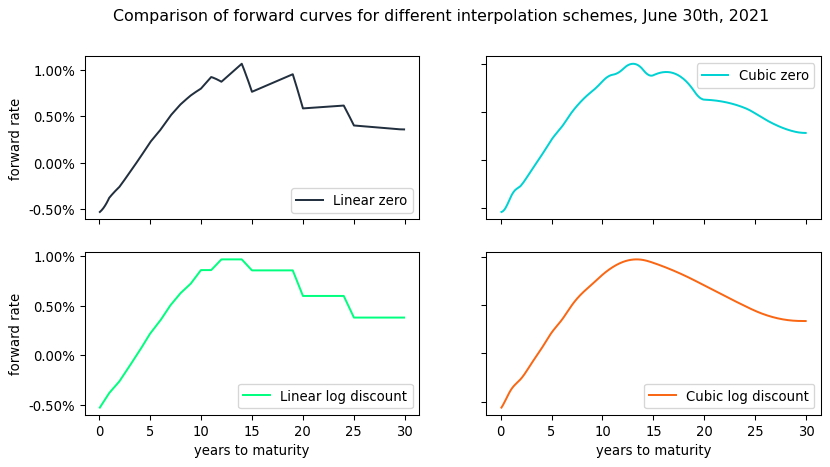

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

def forward_rates(curve: ql.YieldTermStructure, tenors: List[ql.Period]) -> List[Tuple[float, float]]:
    reference_date = curve.referenceDate()
    d_counter = curve.dayCounter()
    dates = [reference_date + tnr for tnr in tenors]
    t = [curve.timeFromReference(d) for d in dates]
    z = [curve.forwardRate(time, time + 1, ql.Compounded, ql.Annual).rate() for time in t]
    return list(zip(t, z))


tenors = [ql.PeriodParser.parse(str(i) + 'm') for i in range(1, 30 * 12)]

y_formatter = StrMethodFormatter('{x:,.2%}')
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=95)
fig.suptitle(f'Comparison of forward curves for different interpolation schemes, {today}')

t, forwards_linear_zero = zip(*forward_rates(swap_ts_linear_zero, tenors))
axs[0, 0].plot(t, forwards_linear_zero, "#222f3e", label="Linear zero")
axs[0, 0].legend()

_, forwards_linear_log_discount = zip(*forward_rates(swap_ts_linear_log_discount, tenors))
axs[1, 0].plot(t, forwards_linear_log_discount, "#00FF7F", label="Linear log discount")
axs[1, 0].legend()

_, forwards_cubic_zero = zip(*forward_rates(swap_ts_cubic_zero, tenors))
axs[0, 1].plot(t, forwards_cubic_zero, "#00d2d3", label="Cubic zero")
axs[0, 1].legend()

_, forwards_cubic_log_discount = zip(*forward_rates(swap_ts_cubic_log_discount, tenors))
axs[1, 1].plot(t, forwards_cubic_log_discount, "#F96714", label="Cubic log discount")
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='years to maturity', ylabel='forward rate')
    ax.yaxis.set_major_formatter(y_formatter)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


Based on the shapes of the presented term structures, a number of conclusions can be drawn:

* linear interpolation on zero rates exhibits a saw-tooth shaped forward curve, which suggests poor stability of the projections
* cubic interpolation on zero rates shows some improvement, compared to linear interpolation, still the forwards are showing fluctuations which are not desired
* linear interpolation on log discounts leads to a staircase shaped forward curve, which means that between the nodes of the curve, forwards are kept constant.
* cubic interpolation on log discounts produces a smooth forward curve.

# Valuation results

`QuantLib` allows to build a zero coupon swap instrument using either a fixed rate or a fixed payment.
Let us first construct one using a fixed rate of 1%.

In [5]:
# ZERO COUPON SWAP DETAILS

swap_type = ql.Swap.Receiver
base_nominal = 1.0e7
start_date = ql.Date(30, ql.December, 2016)
maturity_date = ql.Date(30, ql.December, 2042)
rate = 0.01
rate_day_count = ql.Actual360()
calendar = ql.UnitedStates(ql.UnitedStates.Settlement)

zcs_from_rate = ql.ZeroCouponSwap(swap_type, 
                                  base_nominal, 
                                  start_date, 
                                  maturity_date, 
                                  rate, 
                                  rate_day_count, 
                                  libor_idx, 
                                  calendar)

Now, we can inspect the fixed payment of the swap:

In [6]:
fixed_payment = zcs_from_rate.fixedPayment()
print('Fixed payment of the swap: ', '{:,.0f}'.format(fixed_payment))

Fixed payment of the swap:  3,001,344


Recall that the fixed payment represents the compounded value of base nominal at a given interest rate, minus the initial amount of the base nomnial.

We can validate the above result with a simple computation:

In [7]:
year_fraction = rate_day_count.yearFraction(start_date, maturity_date)
compound = (1.0 + rate)**year_fraction

replicated_payment = base_nominal * (compound - 1.0)

print('Replicated fixed payment: ', '{:,.0f}'.format(replicated_payment))

Replicated fixed payment:  3,001,344


Same swap can be build using the calculated final payment:

In [8]:
zcs_from_payment = ql.ZeroCouponSwap(swap_type, 
                                     base_nominal, 
                                     start_date, 
                                     maturity_date, 
                                     fixed_payment, 
                                     libor_idx, 
                                     calendar)

To price the swap we need a discounting engine.

In [9]:
engine = ql.DiscountingSwapEngine(ts_handle)

zcs_from_payment.setPricingEngine(engine)

We can compare the NPVs of the instrument under different interpolation schemes by simply relinking the `Handle` to a different term structure object.

In [10]:
ts_handle.linkTo(swap_ts_linear_zero)
npv_linear_zero = zcs_from_payment.NPV()
print('NPV using linear zero interpolation: ', '{:,.0f}'.format(npv_linear_zero))

ts_handle.linkTo(swap_ts_linear_log_discount)
npv_linear_log_discount = zcs_from_payment.NPV()
print('NPV using linear log discount interpolation: ', '{:,.0f}'.format(npv_linear_log_discount))

ts_handle.linkTo(swap_ts_cubic_zero)
npv_cubic_zero = zcs_from_payment.NPV()
print('NPV using cubic zero interpolation: ', '{:,.0f}'.format(npv_cubic_zero))

ts_handle.linkTo(swap_ts_cubic_log_discount)
npv_cubic_log_discount = zcs_from_payment.NPV()
print('NPV using cubic log discount interpolation: ', '{:,.0f}'.format(npv_cubic_log_discount))

NPV using linear zero interpolation:  1,795,966
NPV using linear log discount interpolation:  1,794,153
NPV using cubic zero interpolation:  1,788,657
NPV using cubic log discount interpolation:  1,778,770


# Risk analysis results

The library offers a number of methods to analyse the risks associated with this instrument. 

We are going to focus here on the par deltas, being the sensitivity of the market value of the instrument with respect to changes of the par swap rates constituing the term structure used to discount the cash flows and to project the future interest rate fixings of the instrument. 

The sensitivity is computed numerically. Every time `bump_quote` is called on one of the market quotes, the observer receives a notification and the term structure handle is notified, after which the `NPV` is recalculated.

In the end we obtain some interesting sensitivity distributions for various interpolation methods.

In [11]:
def bump_quote(quote_handle: ql.RelinkableQuoteHandle, bump = 0.0001):
    quote_handle.linkTo(ql.SimpleQuote(quote_handle.value() + bump))
    

BUMP = 1.0e-4
SCALING = 1.0e-4

sensitivities_linear_zero = []
sensitivities_cubic_zero = []
sensitivities_linear_log_discount = []
sensitivities_cubic_log_discount = []

for tenor, quote in swap_quotes:  
    bump_quote(quote, BUMP)
    
    ts_handle.linkTo(swap_ts_linear_zero)
    sensitivities_linear_zero.append((tenor, (zcs_from_payment.NPV() - npv_linear_zero) / BUMP * SCALING))
    
    ts_handle.linkTo(swap_ts_linear_log_discount)
    sensitivities_linear_log_discount.append((tenor, (zcs_from_payment.NPV() - npv_linear_log_discount) / BUMP * SCALING))
    
    ts_handle.linkTo(swap_ts_cubic_zero)
    sensitivities_cubic_zero.append((tenor, (zcs_from_payment.NPV() - npv_cubic_zero) / BUMP * SCALING))
    
    ts_handle.linkTo(swap_ts_cubic_log_discount)
    sensitivities_cubic_log_discount.append((tenor, (zcs_from_payment.NPV() - npv_cubic_log_discount) / BUMP * SCALING))
    
    bump_quote(quote, -BUMP)

The graphs below demonstrate the distributions of the par deltas depending on the interpolation scheme.

The sensitivities calculated under a term structure using linear zero and cubic log discount interpolations are visibly different, compared to the profile under the remaining two schemes. In fact, it is very often the case that cubic interpolation schemes display an issue of non-locality of hedges. 

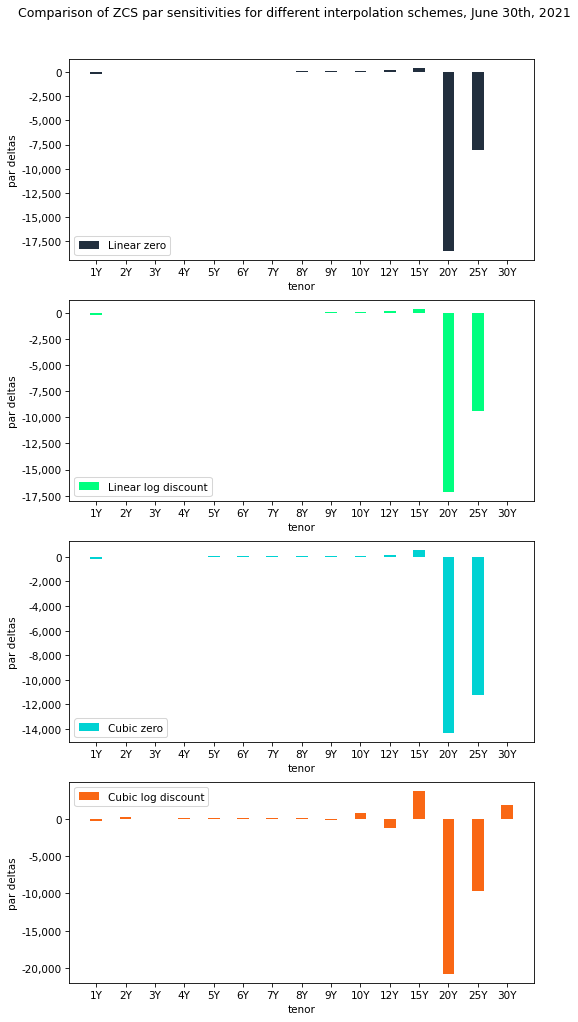

In [12]:
import numpy

width = 0.4
x_axis = numpy.arange(len(swap_quotes))

y_formatter = StrMethodFormatter('{x:,.0f}')
fig, axs = plt.subplots(4, 1, figsize=(8, 14), dpi=75)
fig.subplots_adjust(top=0.93, bottom=0.05)
fig.suptitle(f'Comparison of ZCS par sensitivities for different interpolation schemes, {today}')

grid, deltas_linear_zero = zip(*sensitivities_linear_zero)
grid_str = [str(tnr) for tnr in grid]
axs[0].bar(grid_str, deltas_linear_zero, width, color="#222f3e", label="Linear zero")
axs[0].legend()

_, deltas_linear_log_discount = zip(*sensitivities_linear_log_discount)
axs[1].bar(grid_str, deltas_linear_log_discount, width, color="#00FF7F", label="Linear log discount")
axs[1].legend()

_, deltas_cubic_zero = zip(*sensitivities_cubic_zero)
axs[2].bar(grid_str, deltas_cubic_zero, width, color="#00d2d3", label="Cubic zero")
axs[2].legend()

_, deltas_cubic_log_discount = zip(*sensitivities_cubic_log_discount)
axs[3].bar(grid_str, deltas_cubic_log_discount, width, color="#F96714", label="Cubic log discount")
axs[3].legend()

for ax in axs.flat:
    ax.set(xlabel='tenor', ylabel='par deltas')
    ax.yaxis.set_major_formatter(y_formatter)


In [13]:
print('DV01 using linear zero interpolation: ', '{:,.0f}'.format(sum(deltas_linear_zero)))

print('DV01 using linear log discount interpolation: ', '{:,.0f}'.format(sum(deltas_cubic_zero)))

print('DV01 using cubic zero interpolation: ', '{:,.0f}'.format(sum(deltas_linear_log_discount)))

print('DV01 using cubic log discount interpolation: ', '{:,.0f}'.format(sum(deltas_cubic_log_discount)))

DV01 using linear zero interpolation:  -25,795
DV01 using linear log discount interpolation:  -24,665
DV01 using cubic zero interpolation:  -25,767
DV01 using cubic log discount interpolation:  -25,799
